## Introduction

GitHub repository: https://github.com/devangrai/Transfer-Learning-For-ECG-Classification/tree/master 

Currently, remote monitoring devices such as watches or implants are utilized heavily to provide an enhanced healthcare for patients with periodic heart arrhythmia by constantly collecting heart activity. These devices work by collecting vast amounts of electrocardiogram (ECG) data, which is then interpreted by physicians. However, this poses an issue for physicians — there is often too much data to comb through. Thus comes the introduction of Transfer Learning for ECG classification; the goal is to utilize deep learning, specifically deep convolutional neural networks, to assist the physicians by classifying ECG data. However, such a task can be expensive due to the issue of a deep convolutional neural network requiring vast amounts of labelled data for supervised learning. We can combat this issue by breaking down the training process of the model into a few steps. First, we can pretrain the model on a general dataset of ECG data to obtain a general understanding of the data. Next, we finetune the networks on smaller, more refined, datasets to classify Atrial Fibrillation, which is the most common form of heart arrhythmia. Through the pretraining process, we can implement both supervised and unsupervised approaches to identify patterns and increase relevance of the model.

Our goal is to implement transfer learning, in which we hope that by gathering knowledge to solve one problem, the model can apply the same knowledge to another problem within the same domain. To this end, we will pretrain CNNs on different classifications — beat, rhythm, heart rate, and future prediction. We will then finetune these models to investigate if we can accurately classify Atrial Fibrillation, a common heart arrhythmia, while reducing the number of annotations required in the dataset.

## Scope of Reproducability

There are two main sections discussed in this paper - pretraining the models and finetuning the models. For pretraining the models, we focus on training a beat classifier, a rhythm classifier, and a heart rate classifier on the Icentia11k dataset. For the finetuning of the models, we utilize the Physionet 2017 Challenge dataset, which provides training and validation data.

There were a lot of issues with the code being outdated with the libraries involved, resulting in some problems we will discuss later. We were able to create the pretrained models and finetune the models appropriately.

## Methodology

### Data

#### Icentia11k Dataset

https://arxiv.org/abs/1910.09570

The Icentia11k dataset is the largest (as of October 21, 2019) public electrocardigram dataset. It consists of raw signals for representation learning, and is composed of such data for 11 thousand patients and 2 billion labeled beats. The goal of the dataset is to provide data foundations for semi-supervised electrocadigram models and to promote the discovery of unknown subtypes of arrhythmia and anomalous electrocadigram signal events.

#### PhysioNet 2017 Challenge Dataset

https://physionet.org/content/challenge-2017/1.0.0/

The PhysioNet 2017 Challenge aims to encourage the development of algorithms to classify from a single short ECG lead recording (between 30-60 seconds in length) whether the recording shows normal sinus rhythm, atrial fibrillation, an alternative rhythm, or is too noisy to be classified. The types of cardiac arrhythmias that may be classified include:
- **Origin**: atrial arrhythmia, junctional arrhythmia, or ventricular arrhythmia
- **Rate**: tachycardia ( > 100 beats per minute (bpm) in adults) or bradycardia ( < 60 bpm in adults) or bradycardia ( < 60 bpm in adults)
- **Mechanism**: automaticity, re-entry, triggered
- **AV Conduction**: normal, delayed, blocked
- **Duration**: non-sustained (less than 30 s) or sustained (30 s or longer)

The dataset consists of training and validation data, partitioned separately. The training set contains 8,528 single lead ECG recordings lasting from 9 seconds to just over 60 seconds. The validation set contains 3,658 ECG recordings of similar length.

The PhysioNet 2017 Challenge Dataset was downloaded externally following instructions on the main page.

After downloading the PhysioNet 2017 Challenge Dataset, we will preprocess the data. Specifically, we will normalize the dataset, adapt the sampling frequency to be similar to the Icentia11k, zero-pad the recordings, and finally split the dataset into train and test sets.

In [5]:
# Finetuning code
# Finetuning is done on Physionet2017 dataset, here we are preprocessing the data

from finetuning import datasets
from finetuning.utils import train_test_split
from transplant.utils import save_pkl
data = datasets.get_challenge17_data(
   db_dir='../data/physionet.org/files/challenge-2017/1.0.0/training',
   fs=250,  # keep sampling frequency the same as Icentia11k
   pad=16384,  # zero-pad recordings to keep the same length at about 65 seconds
   normalize=True)  # normalize each recording with mean and std computed over the entire dataset
# maintain class ratio across both train and test sets by using the `stratify` argument
train_set, test_set = train_test_split(
   data, test_size=0.2, stratify=data['y'])
save_pkl('data/physionet_train.pkl', **train_set)
save_pkl('data/physionet_test.pkl', **test_set)

../data/physionet.org/files/challenge-2017/1.0.0/training


### Model

There are two types of models - pretraining and finetuning. For each type of model, there are three main models for pretraining: beat classification, rhythm classification, and heart rate classification.

#### Pretraining Models

All the pretraining models are trained on the Icentia11k dataset.

- **Beat Classification**: The beat classification model's goal is to classify individual heartbeats into different categories, such as normal beats, premature ventricular contractions (PVCs), and atrial premature beats (APBs), to name a few. The model is trained on the Icentia11k dataset, which includes labeled ECG segments with annotations indicating the type of beat. The model architecture can vary between ResNet18, ResNet34, or others -- specifically, we have used ResNet18 for reproducability -- which is finetuned with the Icentia11k dataset for the task of beat classification. The final layer of the model is a softmax activation to output probability scores for each beat class.

- **Rhythm Classification**: The rhythm classification pretrained model is designed for the task of rhythm classification, which involves categorizing longer segments of ECG data into different rhythm classes, such as normal sinus rhythm, atrial fibrillation, sinus tachycardia, to name a few. It is trained on the Icentia11k dataset with annotations indicating the rhythm type for each segment. Similar to the beat classification pretrained model, the architecture is adapted from ResNet18 and finetuned for rhythm classification, with modifications to handle longer input sequences. Finally, the output layer of the model consists of a softmax activation to predict probability scores over each rhythm class.

- **Heart Rate Classification**: The heart rate classification pretrained model is designed for the task of heart rate classification, which involves classifying ECG segments based on their heart rate characteristics, with labels such as normal heart rate, bradycardia, and more. It is also trained on the Icentia11k dataset, with labeled annotations corresponding to heart rates. Similar to the other pretrained models, the model architecture of the heart rate classification model is also an adaptation of ResNet18, finetuned with the Icentia11k dataset for the heart rate classification task. Similar to the other models, it also incorporates a final layer of softmax activation to predict probability scores over each heart rate class.

#### Finetuning Models

All the finetuning models are trained on the PhysioNet 2017 Challenge Dataset.

- **Beat Classification**: The pretrained beat classification model is fine-tuned on the PhysioNet 2017 Challenge Dataset to become more specific. This process involves modifying the best weights from the pretrained beat classification model to adapt to nuances and characteristics of the new dataset.

- **Rhythm Classification**: The pretrained rhythm classification model is fine-tuned on the PhysioNet 2017 Challenge Dataset to focus on the rhythm domain in the target dataset. The goal of the fine-tuning is to update the model parameters and make it more adept at distinguishing between the various rhythm classes in the PhysioNet 2017 Challenge Dataset, with a goal of better classification.

- **Heart Rate Classification**: The pretrained heart rate classification model is fine-tuned on the PhysioNet 2017 Challenge Dataset to fine-tune for the target dataset. The model parameters are adjusted to allow the model to adapt its representations to the specific heart rate patterns present in the PhysioNet 2017 Challenge Dataset, which may vary from patterns seen in the pretrained dataset.

### Training

*   Pretraining models
*   Finetuning models



To train the model on the full dataset, we would require more storage to host the entire Icentia11k dataset.

#### Pretraining Models

Below, we have the pretraining code to run functions that create the beat classification pretrained model, rhythm classification pretrained model, and heart rate classification pretrained model.

For simplicity, we have separated all of the data preprocessing and training code to separate python files, and utilize scripts to perform the task at hand.

In [ ]:
# Pretrainer code
# Pretrains the beat classification task on the Icentia11k dataset for 50 epochs
!python -m pretraining.trainer \
--job-dir "jobs/beat_classification" \
--task "beat" \
--train "../data/icentia11k" \
--arch "resnet18" \
--epochs 50

In [ ]:
# Pretrainer code
# Pretrains the rhythm classification task on the Icentia11k dataset for 50 epochs
!python -m pretraining.trainer \
--job-dir "jobs/rhythm_classification" \
--task "rhythm" \
--train "../data/icentia11k" \
--arch "resnet18" \
--epochs 50

In [ ]:
# Pretrainer code
# Pretrains the heart rate classification task on the Icentia11k dataset for 50 epochs
!python -m pretraining.trainer \
--job-dir "jobs/hr_classification" \
--task "hr" \
--train "../data/icentia11k" \
--arch "resnet18" \
--epochs 50

2024-04-30 19:52:26.364717: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 19:52:26.612797: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 19:52:27.593063: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 19:52:29.604039: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Creating working directory in jobs/hr_classification
Setting random state 8530
Building train data generators
Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead
Building model ...
# model parameters: 4,494,5

#### Finetuning Models

Below, we have the finetuning code to run functions that create the beat classification pretrained model, rhythm classification pretrained model, and heart rate classification pretrained model.

For simplicity, we have separated all of the data preprocessing and training code to separate python files, and utilize scripts to perform the task at hand.

In the finetuning, we will use the resnet18 weights from each specific pretrained model that we determined to be the best and finetune the model using those pretrained weights.

In [12]:
# First, we need to convert the .weights.h5 files to .weights files for formatting
import h5py
import numpy as np

def convert_hdf5_to_binary(hdf5_filename, binary_filename):
    # Load the HDF5 file
    with h5py.File(hdf5_filename, 'r') as f:
        # Iterate over all items in the file and save their arrays to a binary file
        with open(binary_filename, 'wb') as bin_file:
            for layer, g in f.items():
                for k, v in g.items():
                    if isinstance(v, h5py.Dataset):  # Ensure it's a dataset
                        data = np.array(v)  # Convert to numpy array
                        data.tofile(bin_file)  # Write to binary file

# Convert file format of pretrained models 
convert_hdf5_to_binary('jobs/beat_classification/resnet18.weights.h5', 'jobs/beat_classification/resnet18.weights')
convert_hdf5_to_binary('jobs/rhythm_classification/resnet18.weights.h5', 'jobs/rhythm_classification/resnet18.weights')
convert_hdf5_to_binary('jobs/hr_classification/resnet18.weights.h5', 'jobs/hr_classification/resnet18.weights')

In [ ]:
!python -m finetuning.trainer \
--job-dir "jobs/af_classification" \
--train "data/physionet_train.pkl" \
--test "data/physionet_test.pkl" \
--weights-file "jobs/beat_classification/resnet18.weights.h5" \
--val-size 0.0625 \
--arch "resnet18" \
--batch-size 2 \
--epochs 50

2024-05-01 20:23:04.421609: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-01 20:23:04.425953: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-01 20:23:04.479119: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-01 20:23:05.937175: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Creating working directory in jobs/af_classification
Setting random state 29054
Loading train data from data/physionet_train.pkl ...
Split data into train 93.74% and validation 6.26%
Loading test data from data/physionet_test.pkl ...
Train data shape: (6395, 16384, 1)

In [ ]:
!python -m finetuning.trainer \
--job-dir "jobs/af_rhythm_classification" \
--train "data/physionet_train.pkl" \
--test "data/physionet_test.pkl" \
--weights-file "jobs/rhythm_classification/resnet18.weights.h5" \
--val-size 0.0625 \
--arch "resnet18" \
--batch-size 8 \
--epochs 50

2024-05-02 21:22:43.092663: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-02 21:22:43.096986: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-02 21:22:43.150794: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-02 21:22:44.059806: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Creating working directory in jobs/af_rhythm_classification
Setting random state 30191
Loading train data from data/physionet_train.pkl ...
Split data into train 93.74% and validation 6.26%
Loading test data from data/physionet_test.pkl ...
Train data shape: (6395, 16

In [ ]:
!python -m finetuning.trainer \
--job-dir "jobs/af_hr_classification" \
--train "data/physionet_train.pkl" \
--test "data/physionet_test.pkl" \
--weights-file "jobs/hr_classification/resnet18.weights.h5" \
--val-size 0.0625 \
--arch "resnet18" \
--batch-size 8 \
--epochs 50

2024-05-07 01:51:17.016661: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-07 01:51:17.020872: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-07 01:51:17.073420: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-07 01:51:17.983021: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Creating working directory in jobs/af_hr_classification
Setting random state 23562
Loading train data from data/physionet_train.pkl ...
Split data into train 93.74% and validation 6.26%
Loading test data from data/physionet_test.pkl ...
Test is loaded
Train data shape

### Evaluation

#### Pretrained Models

We can analyze the metrics from the epochs that are saved to each tasks 'history.csv' file, and extract the best checkpoint.

In [4]:
# Analyzing Beat Classification pretrained data file

import csv
import pandas as pd

# Display CSV file
df_beat_classification = pd.read_csv('jobs/beat_classification/history.csv')
print(df_beat_classification)
        
# Extracts best checkpoint for beat classification
best_cp = 0
max_acc = float('-inf')
with open('jobs/beat_classification/history.csv', 'r') as f:
    # Create a CSV reader object
    reader = csv.reader(f)
    # Iterate over the rows in the CSV file
    for row in reader:
        if row[0] == "epoch":
            continue
        curr_cp = float(row[0])
        curr_acc = float(row[1])
        if curr_acc > max_acc:
            max_acc = curr_acc
            best_cp = curr_cp
best_cp = str(int(best_cp)+1)
if len(best_cp) == 1:
    best_cp = '0' + best_cp
from pretraining.utils import get_pretrained_weights
cp_file = 'jobs/beat_classification/epoch_' + best_cp + '/model.weights.h5'
print("Checkpoint file chosen: " + cp_file + ". Saving weights.")
resnet18 = get_pretrained_weights(
   checkpoint_file=cp_file,
   task='beat',
   arch='resnet18')
resnet18.save_weights('jobs/beat_classification/resnet18.weights.h5')

    epoch       acc      loss  val_acc  val_loss
0       0  0.792813  0.647763      NaN       NaN
1       1  0.852813  0.455254      NaN       NaN
2       2  0.854062  0.447250      NaN       NaN
3       3  0.866875  0.416095      NaN       NaN
4       4  0.871875  0.418627      NaN       NaN
5       5  0.858125  0.459310      NaN       NaN
6       6  0.863750  0.443068      NaN       NaN
7       7  0.862188  0.415087      NaN       NaN
8       8  0.845000  0.468055      NaN       NaN
9       9  0.845000  0.467683      NaN       NaN
10     10  0.868125  0.397917      NaN       NaN
11     11  0.861875  0.411492      NaN       NaN
12     12  0.868125  0.397341      NaN       NaN
13     13  0.842500  0.440590      NaN       NaN
14     14  0.825938  0.470930      NaN       NaN
15     15  0.819687  0.500002      NaN       NaN
16     16  0.841250  0.444819      NaN       NaN
17     17  0.846250  0.422891      NaN       NaN
18     18  0.850625  0.404299      NaN       NaN
19     19  0.836250 

2024-05-07 20:57:35.377910: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-07 20:57:35.382455: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-07 20:57:35.440932: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-07 20:57:37.109834: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Checkpoint file chosen: jobs/beat_classification/epoch_50/model.weights.h5. Saving weights.


In [5]:
# Analyzing Rhythm Classification pretrained data file

import csv
import pandas as pd

# Display CSV file
df_rhythm_classification = pd.read_csv('jobs/rhythm_classification/history.csv')
print(df_rhythm_classification)
        
# Extracts best checkpoint for beat classification
best_cp = 0
max_acc = float('-inf')
with open('jobs/rhythm_classification/history.csv', 'r') as f:
    # Create a CSV reader object
    reader = csv.reader(f)
    # Iterate over the rows in the CSV file
    for row in reader:
        if row[0] == "epoch":
            continue
        curr_cp = float(row[0])
        curr_acc = float(row[1])
        if curr_acc > max_acc:
            max_acc = curr_acc
            best_cp = curr_cp
best_cp = str(int(best_cp)+1)
if len(best_cp) == 1:
    best_cp = '0' + best_cp
from pretraining.utils import get_pretrained_weights
cp_file = 'jobs/rhythm_classification/epoch_' + best_cp + '/model.weights.h5'
print("Checkpoint file chosen: " + cp_file + ". Saving weights.")
resnet18 = get_pretrained_weights(
   checkpoint_file=cp_file,
   task='rhythm',
   arch='resnet18')
resnet18.save_weights('jobs/rhythm_classification/resnet18.weights.h5')

    epoch       acc      loss  val_acc  val_loss
0       0  0.825312  0.574072      NaN       NaN
1       1  0.887187  0.371821      NaN       NaN
2       2  0.890938  0.310860      NaN       NaN
3       3  0.895625  0.292340      NaN       NaN
4       4  0.906563  0.251070      NaN       NaN
5       5  0.913750  0.259517      NaN       NaN
6       6  0.908437  0.260094      NaN       NaN
7       7  0.921562  0.231802      NaN       NaN
8       8  0.916562  0.224458      NaN       NaN
9       9  0.922188  0.203089      NaN       NaN
10     10  0.908750  0.255392      NaN       NaN
11     11  0.915937  0.208920      NaN       NaN
12     12  0.912188  0.227442      NaN       NaN
13     13  0.911250  0.240738      NaN       NaN
14     14  0.915000  0.235982      NaN       NaN
15     15  0.924062  0.228670      NaN       NaN
16     16  0.924062  0.230295      NaN       NaN
17     17  0.905312  0.290760      NaN       NaN
18     18  0.911563  0.249939      NaN       NaN
19     19  0.901250 

In [6]:
# Analyzing HR Classification pretrained data file

import csv
import pandas as pd

# Display CSV file
df_hr_classification = pd.read_csv('jobs/hr_classification/history.csv')
print(df_hr_classification)
        
# Extracts best checkpoint for beat classification
best_cp = 0
max_acc = float('-inf')
with open('jobs/hr_classification/history.csv', 'r') as f:
    # Create a CSV reader object
    reader = csv.reader(f)
    # Iterate over the rows in the CSV file
    for row in reader:
        if row[0] == "epoch":
            continue
        curr_cp = float(row[0])
        curr_acc = float(row[1])
        if curr_acc > max_acc:
            max_acc = curr_acc
            best_cp = curr_cp
best_cp = str(int(best_cp)+1)
if len(best_cp) == 1:
    best_cp = '0' + best_cp
from pretraining.utils import get_pretrained_weights
cp_file = 'jobs/hr_classification/epoch_' + best_cp + '/model.weights.h5'
print("Checkpoint file chosen: " + cp_file + ". Saving weights.")
resnet18 = get_pretrained_weights(
   checkpoint_file=cp_file,
   task='hr',
   arch='resnet18')
resnet18.save_weights('jobs/hr_classification/resnet18.weights.h5')

    epoch       acc      loss  val_acc  val_loss
0       0  0.736562  0.739197      NaN       NaN
1       1  0.839688  0.424977      NaN       NaN
2       2  0.883438  0.324937      NaN       NaN
3       3  0.886563  0.304419      NaN       NaN
4       4  0.893438  0.296591      NaN       NaN
5       5  0.904063  0.255318      NaN       NaN
6       6  0.917813  0.235012      NaN       NaN
7       7  0.920625  0.226796      NaN       NaN
8       8  0.913437  0.234389      NaN       NaN
9       9  0.930313  0.187003      NaN       NaN
10     10  0.927500  0.187643      NaN       NaN
11     11  0.941875  0.151253      NaN       NaN
12     12  0.950938  0.138618      NaN       NaN
13     13  0.941250  0.161665      NaN       NaN
14     14  0.940313  0.165415      NaN       NaN
15     15  0.938438  0.172570      NaN       NaN
16     16  0.939062  0.170286      NaN       NaN
17     17  0.944375  0.156504      NaN       NaN
18     18  0.942500  0.160961      NaN       NaN
19     19  0.942813 

#### Finetuned Models

Now, we will move on to analyze the accuracy of each pretrained model finetuned on electrocardigram data - specifically to identify atrial fibrillation.

In [11]:
# Analyzing Beat Classification finetuned data file

import csv
import pandas as pd

# Display CSV file
df_beat_finetuned_classification = pd.read_csv('jobs/af_classification/history.csv')
print(df_beat_finetuned_classification)

    epoch       acc      loss   val_acc  val_loss
0       0  0.682095  0.778293  0.714286  0.905695
1       1  0.736982  0.644969  0.707260  0.969271
2       2  0.764347  0.593030  0.681499  0.980034
3       3  0.784363  0.549391  0.758782  1.025008
4       4  0.801876  0.512976  0.697892  2.075286
5       5  0.819234  0.490271  0.737705  0.931363
6       6  0.821423  0.471886  0.747073  1.182074
7       7  0.834402  0.450635  0.784543  0.789043
8       8  0.840657  0.441518  0.786885  0.797855
9       9  0.835496  0.436325  0.793911  0.827866
10     10  0.847068  0.413435  0.789227  0.873293
11     11  0.847381  0.406676  0.772834  0.884702
12     12  0.855199  0.396138  0.810304  0.827814
13     13  0.854574  0.385406  0.744731  0.978486
14     14  0.863800  0.374920  0.789227  0.950109
15     15  0.869116  0.362767  0.747073  1.441212
16     16  0.875840  0.346364  0.742389  1.148374
17     17  0.879437  0.342360  0.789227  0.866970
18     18  0.876935  0.332659  0.782201  1.011212


In [12]:
# Analyzing Rhythm Classification finetuned data file

import csv
import pandas as pd

# Display CSV file
df_rhythm_finetuned_classification = pd.read_csv('jobs/af_rhythm_classification/history.csv')
print(df_rhythm_finetuned_classification)

    epoch       acc      loss   val_acc  val_loss
0       0  0.648163  0.797607  0.672131  0.767079
1       1  0.704300  0.698782  0.747073  0.719099
2       2  0.743862  0.626323  0.751756  0.783479
3       3  0.762783  0.594511  0.770492  0.672116
4       4  0.776075  0.562408  0.786885  0.565462
5       5  0.795778  0.537259  0.777518  0.617675
6       6  0.801407  0.519629  0.786885  0.583771
7       7  0.807506  0.507050  0.800937  0.529738
8       8  0.815012  0.492250  0.805621  0.507522
9       9  0.820485  0.479422  0.817330  0.536692
10     10  0.825645  0.465471  0.819672  0.477217
11     11  0.836122  0.449493  0.824356  0.491928
12     12  0.841282  0.434171  0.822014  0.525541
13     13  0.846755  0.422661  0.819672  0.527958
14     14  0.851916  0.412457  0.805621  0.505414
15     15  0.852697  0.395729  0.826698  0.471845
16     16  0.864113  0.374071  0.819672  0.485479
17     17  0.868491  0.373471  0.831382  0.493325
18     18  0.873339  0.351230  0.831382  0.517680


In [13]:
# Analyzing Heart Rate Classification finetuned data file

import csv
import pandas as pd

# Display CSV file
df_hr_finetuned_classification = pd.read_csv('jobs/af_hr_classification/history.csv')
print(df_hr_finetuned_classification)

    epoch       acc      loss   val_acc  val_loss
0       0  0.670993  0.795729  0.707260  0.755404
1       1  0.726661  0.675070  0.702576  0.842312
2       2  0.754496  0.607747  0.768150  0.662192
3       3  0.781392  0.572627  0.777518  0.645487
4       4  0.788585  0.545920  0.770492  0.636895
5       5  0.802346  0.522593  0.800937  0.571423
6       6  0.812823  0.493014  0.775176  0.601688
7       7  0.829242  0.471491  0.796253  0.579748
8       8  0.830180  0.464418  0.765808  0.655028
9       9  0.833307  0.457449  0.817330  0.565479
10     10  0.839719  0.439859  0.822014  0.599383
11     11  0.840188  0.432964  0.826698  0.555495
12     12  0.854418  0.421985  0.824356  0.547615
13     13  0.854418  0.408780  0.784543  0.637361
14     14  0.859265  0.400861  0.814988  0.636933
15     15  0.863487  0.384997  0.817330  0.606204
16     16  0.865833  0.375256  0.819672  0.734191
17     17  0.867866  0.367020  0.824356  0.677394
18     18  0.872400  0.365119  0.805621  0.760553


## Results

### Pretrained Models

From the results of the evaluation of the pretrained model, we can note that the pretrained models already have moderately high accuracies, indicating that the fine-tuned model should perform much better at the main task at hand.
From the pretrained models above, we ran 50 epochs per model. These are the final notable statistics:
- Beat Classification Pretrained Model: Best accuracy of 91.5625% in Epoch 50.
- Rhythm Classification Pretrained Model: Best accuracy of 93.3125% in Epoch 44.
- Heart Rate Classification Pretrained Model: Best accuracy of 95.0625% in Epoch 38.

We can analyze the accuracies of the pretrained models through visualization.

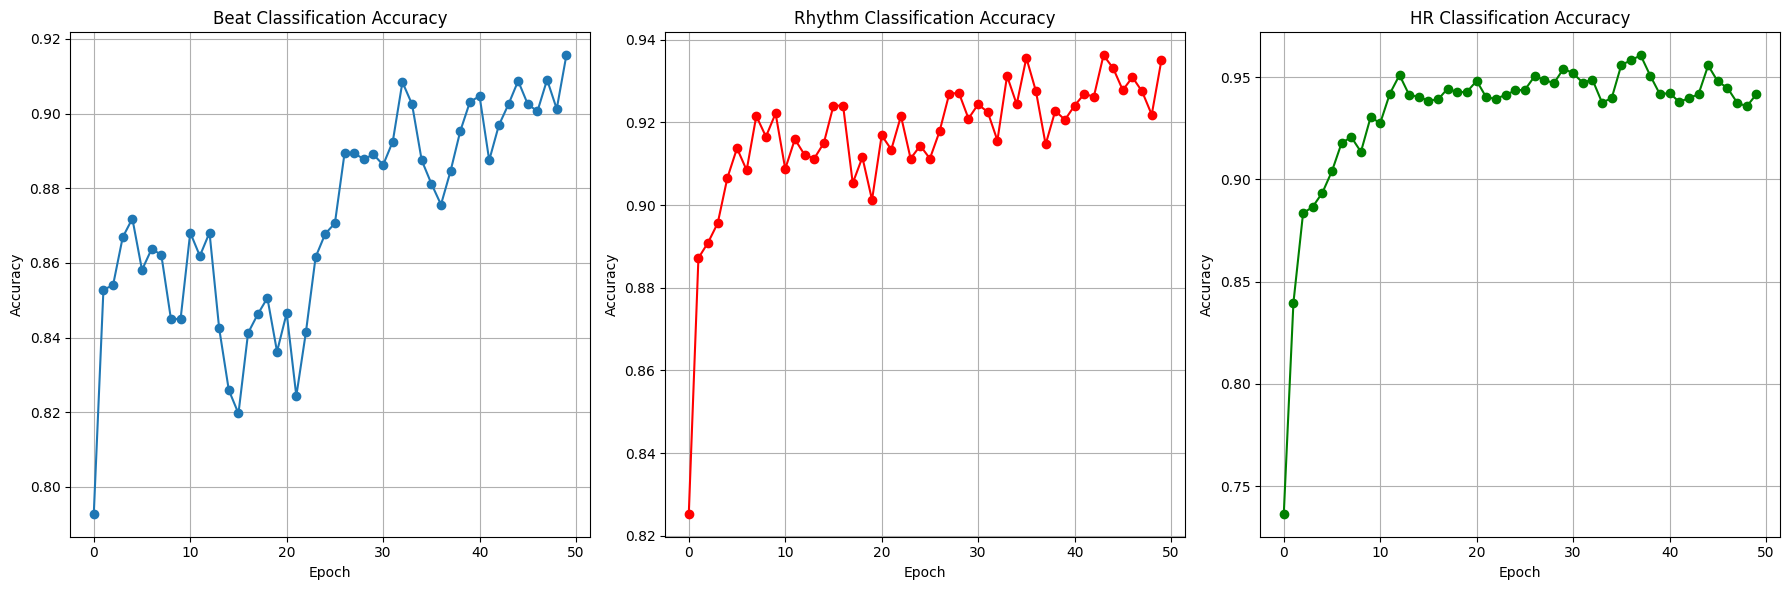

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plot for df_beat_classification
axes[0].plot(df_beat_classification['epoch'], df_beat_classification['acc'], marker='o')
axes[0].set_title('Beat Classification Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].grid(True)

# Plot for df_rhythm_classification
axes[1].plot(df_rhythm_classification['epoch'], df_rhythm_classification['acc'], marker='o', color='red')
axes[1].set_title('Rhythm Classification Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True)

# Plot for df_hr_classification
axes[2].plot(df_hr_classification['epoch'], df_hr_classification['acc'], marker='o', color='green')
axes[2].set_title('HR Classification Accuracy')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy')
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

We can see the accuracy increase normally for all of the pretrained models, which is expected. It is interesting to note the training accuracy drop for a few epochs in the beat classification model. This suggests that the learning rate may be too aggressive and we are overshooting in the gradient descent.

We can continue our analysis with some plots to analyze the losses during training.

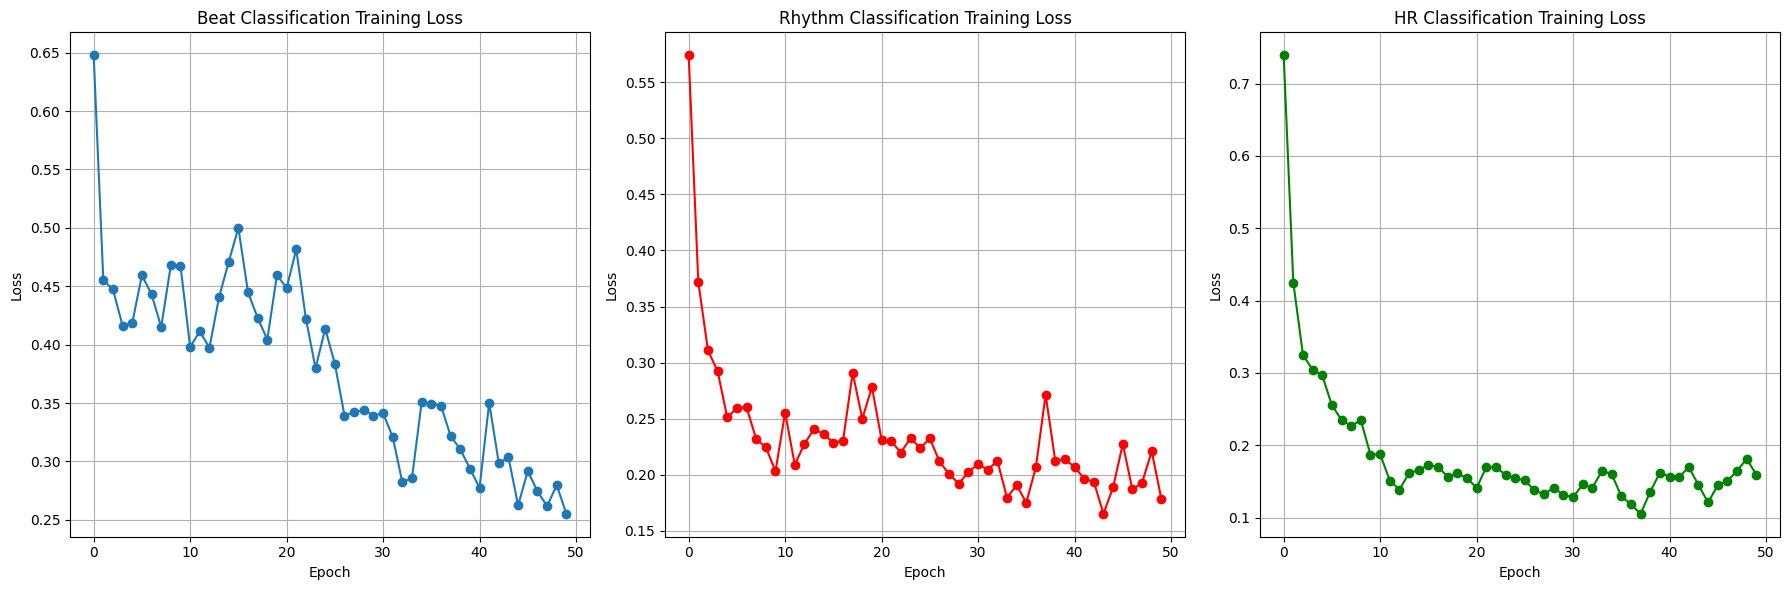

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plot for df_beat_classification
axes[0].plot(df_beat_classification['epoch'], df_beat_classification['loss'], marker='o')
axes[0].set_title('Beat Classification Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)

# Plot for df_rhythm_classification
axes[1].plot(df_rhythm_classification['epoch'], df_rhythm_classification['loss'], marker='o', color='red')
axes[1].set_title('Rhythm Classification Training Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].grid(True)

# Plot for df_hr_classification
axes[2].plot(df_hr_classification['epoch'], df_hr_classification['loss'], marker='o', color='green')
axes[2].set_title('HR Classification Training Loss')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

The training losses seem to be normal for all of the pretrained models. We can note that there are quite a few spikes for beat classification and a few for rhythm classification, suggesting that the learning rate may need some adjustments. We could also benefit from increasing the batch size. For the purpose of recreating the paper, we only ran the model for 50 epochs, but it appears that the training loss seems to be fluctuating less.

### Finetuned Models

From the results of the evaluation of the finetuned models, we can note that regardless of the pretrained model used, the finetuned models worked extremely well on the task at hand.
From the finetuned models above, we ran 50 epochs per model. These are the final notable statistics:
- Beat Classification Pretrained Model: Best training accuracy of 97.7326% and validation accuracy of 79.3911% in Epoch 45.
- Rhythm Classification Pretrained Model: Best training accuracy of 96.6693% and validation accuracy of 81.4988% in Epoch 41.
- Heart Rate Classification Pretrained Model: Best training accuracy of 95.0430% and validation accuracy of 79.3911% in Epoch 33.

We can begin our analysis of the finetuned models by looking at the training and validation accuracy losses.

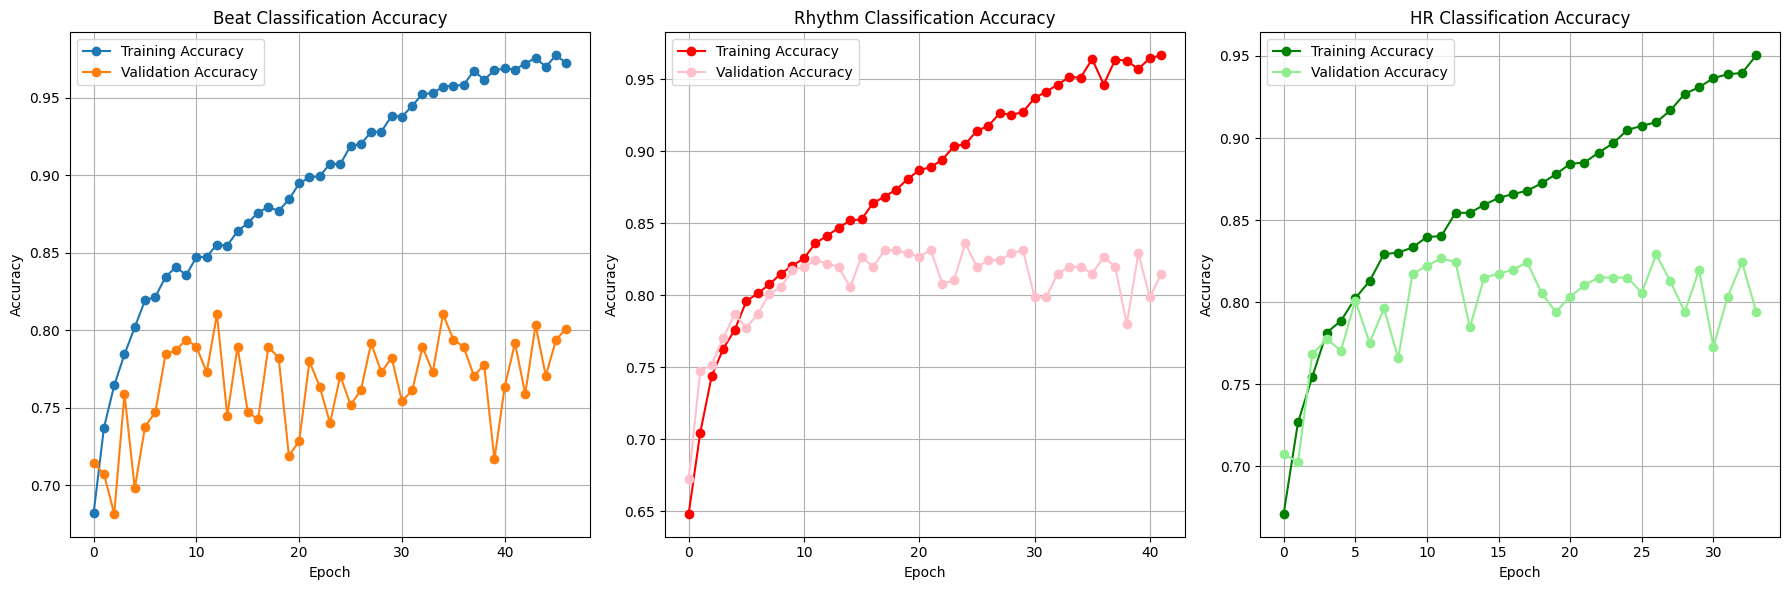

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the DataFrames are already loaded
# df_beat_classification = pd.read_csv('path_to_beat_data.csv')
# df_rhythm_classification = pd.read_csv('path_to_rhythm_data.csv')
# df_hr_classification = pd.read_csv('path_to_hr_data.csv')

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plot training and validation accuracy for df_beat_classification
axes[0].plot(df_beat_finetuned_classification['epoch'], df_beat_finetuned_classification['acc'], marker='o', label='Training Accuracy')
axes[0].plot(df_beat_finetuned_classification['epoch'], df_beat_finetuned_classification['val_acc'], marker='o', label='Validation Accuracy')
axes[0].set_title('Beat Classification Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Plot training and validation accuracy for df_rhythm_classification
axes[1].plot(df_rhythm_finetuned_classification['epoch'], df_rhythm_finetuned_classification['acc'], marker='o', label='Training Accuracy', color='red')
axes[1].plot(df_rhythm_finetuned_classification['epoch'], df_rhythm_finetuned_classification['val_acc'], marker='o', label='Validation Accuracy', color='pink')
axes[1].set_title('Rhythm Classification Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

# Plot training and validation accuracy for df_hr_classification
axes[2].plot(df_hr_finetuned_classification['epoch'], df_hr_finetuned_classification['acc'], marker='o', label='Training Accuracy', color='green')
axes[2].plot(df_hr_finetuned_classification['epoch'], df_hr_finetuned_classification['val_acc'], marker='o', label='Validation Accuracy', color='lightgreen')
axes[2].set_title('HR Classification Accuracy')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy')
axes[2].legend()
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


From the plots above, we can see the training accuracy for each of the finetuned models consistently increase, which is expected. The validation accuracies fluctate heavily for beat classification and heart rate classification, suggesting that the learning rate is too high and we should train the model for more epochs. 

We can also look at the training and validation losses for the finetuned models to get a better understanding of the models' performances.

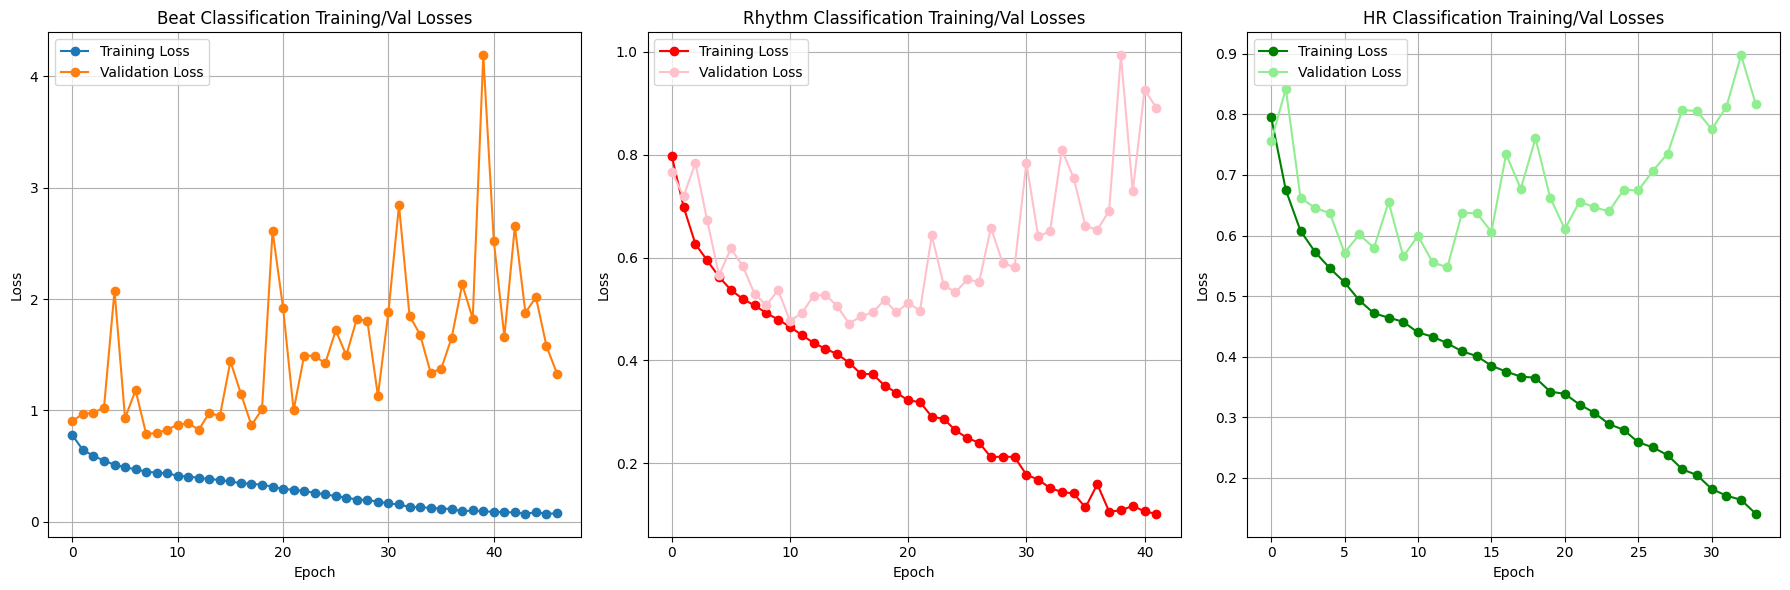

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the DataFrames are already loaded
# df_beat_classification = pd.read_csv('path_to_beat_data.csv')
# df_rhythm_classification = pd.read_csv('path_to_rhythm_data.csv')
# df_hr_classification = pd.read_csv('path_to_hr_data.csv')

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plot training and validation accuracy for df_beat_classification
axes[0].plot(df_beat_finetuned_classification['epoch'], df_beat_finetuned_classification['loss'], marker='o', label='Training Loss')
axes[0].plot(df_beat_finetuned_classification['epoch'], df_beat_finetuned_classification['val_loss'], marker='o', label='Validation Loss')
axes[0].set_title('Beat Classification Training/Val Losses')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Plot training and validation accuracy for df_rhythm_classification
axes[1].plot(df_rhythm_finetuned_classification['epoch'], df_rhythm_finetuned_classification['loss'], marker='o', label='Training Loss', color='red')
axes[1].plot(df_rhythm_finetuned_classification['epoch'], df_rhythm_finetuned_classification['val_loss'], marker='o', label='Validation Loss', color='pink')
axes[1].set_title('Rhythm Classification Training/Val Losses')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

# Plot training and validation accuracy for df_hr_classification
axes[2].plot(df_hr_finetuned_classification['epoch'], df_hr_finetuned_classification['loss'], marker='o', label='Training Loss', color='green')
axes[2].plot(df_hr_finetuned_classification['epoch'], df_hr_finetuned_classification['val_loss'], marker='o', label='Validation Loss', color='lightgreen')
axes[2].set_title('HR Classification Training/Val Losses')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].legend()
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


Unfortunately, it appears that the validation loss is extremely high. For a good model, the validation loss should follow the trend of the training loss but be slightly higher. In our case, the training loss decreases sharply, especially for rhythm and heart rate, but the validation loss fluctuates at a higher overall level. This suggests that the model is sharply overfitting to the training data.

### Model Comparison

While recreating the paper, we were unable to properly utilize the test data for the finetuned models. This had to do with many issues with the code from the original paper being outdated - Keras and Tensorflow both were incompatible. For this reason, we have resorted to analyzing the training and validation accuracies and losses to compare the models.

Overall, through this paper, we came up with three pretrained models, one for beat classification, one for rhythm classification, and one for heart rate classification. We then finetuned each of these models on Atrial Fibrillation detection using the PhysioNet 2017 Challenge dataset. Although we do not have test data to properly gather the accuracy of the model, from the training and validation accuracies and losses, it appears that the best model overall the beat classification pretrained model finetuned on atrial fibrillation detection. This is because the training loss decreases much more slowly and while the validation loss fluctates, it is much lower than the other models. This suggests that the model does not overfit to the training data, unlike the other two models. In addition, the validation loss being lower is a good sign as well.

### Discussion

Overall, this paper is not fully reproducible. This is because the code is outdated compared to the Keras and Tensorflow libraries, even when using the versions suggested in the paper. This results in a lot of debugging in the code, such as updating files and functions. Additionally, we were unable to access the test data, resulting in no proper way of analyzing the finetuned models. Lastly, our results were negative, suggesting that we needed more epochs to train the model for longer.

During the reproduction, it was easy to understand the goals of the paper. However, it was hard to get the datasets, as for they were extremely big files. Additionally, there was a lot of work needed to debug the training files to ensure that the models trained properly. We should also note that we had to use a VM Instance on the Google Cloud Platform to host our dataset, which required 384GB of disk space. Additionally, training the pretrained models and finetuned models took more than 3 days of GPU time. Lastly, we used 50 training epochs.

In the next phase, we would start by making sure that we can properly access the test data. This is a necessary step to properly analyze our finetuned models and make assertive statements about the strengths and weaknesses of the models. We would also run the model for more epochs to see if the training and validation losses stop fluctuating. Lastly, we would try to finetune our pretrained models on other aspects of cardiac arrhytmias,

### References

- Weimann, K., Conrad, T.O.F. Transfer learning for ECG classification. Sci Rep 11, 5251 (2021). https://doi.org/10.1038/s41598-021-84374-8
- Shawn Tan, Guillaume Androz, Ahmad Chamseddine, Pierre Fecteau, Aaron Courville, Yoshua Bengio, & Joseph Paul Cohen. (2019). Icentia11K: An Unsupervised Representation Learning Dataset for Arrhythmia Subtype Discovery.
- Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.